In [1]:
import tensorflow as tf

In [2]:
import os
from skimage import io
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import SimpleITK as sitk
import glob
from keras.preprocessing.image import load_img

In [ ]:
# from nibabel.testing import data_path
example_filename = os.path.join(os.getcwd(), "MosMedData/CT-23/", 'study_0950.nii.gz')

/home/lih/.conda/envs/tf_cpu_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/lih/.conda/envs/tf_cpu_env/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:140: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(


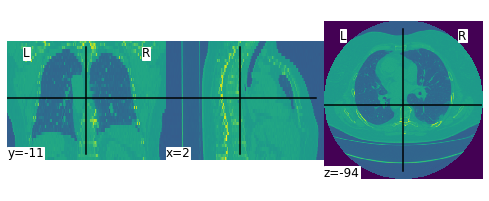

In [64]:
from nilearn import plotting
plotting.plot_img(example_filename)

In [61]:
import nibabel as nib
img = nib.load(example_filename)
img.shape
#print(img)

(512, 512, 38)

In [56]:
import numpy as np
import nibabel as nib
img_nii = nib.Nifti1Image(x_abnormal_train[1,:,:], np.eye(4))
img_nii.shape
nib.save(img_nii, os.path.join('/home/lih/research_code/pixelData/stroke_1', '35_left_1.nii'))  

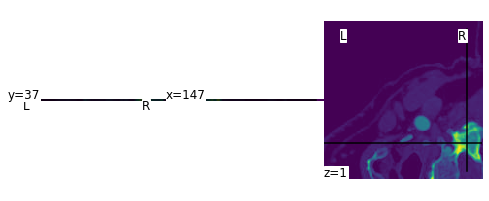

In [65]:
from nilearn import plotting
plotting.plot_img(img_nii)

In [3]:
os.getcwd()

'/home/lih/research_code'

In [3]:
# Make a directory to store the data.
os.makedirs("pixelData")

In [4]:
# Unzip data in the newly created directory.
with zipfile.ZipFile("stroke_0.zip", "r") as z_fp:
    z_fp.extractall("./pixelData/")
with zipfile.ZipFile("stroke_1.zip", "r") as z_fp:
    z_fp.extractall("./pixelData/")

In [4]:
from keras.preprocessing.image import load_img

In [3]:
# load the image
img = load_img('/home/lih/research_code/pixelData/stroke_1/7_left/106.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
#img.show()

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(170, 170)


In [4]:
from keras.preprocessing.image import img_to_array
# convert to numpy array
img_array = img_to_array(img)
print(img_array.dtype)
print(img_array.shape)

float32
(170, 170, 3)


In [5]:
# Folder "stroke_0" consist of Ultrasound scans without stroke,
normal_scan_paths = [
    os.path.join(os.getcwd(), "pixelData/stroke_0", x)
    for x in os.listdir("pixelData/stroke_0")
]
# Folder "stroke_1" consist of Ultrasound scans having stroke,
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "pixelData/stroke_1", x)
    for x in os.listdir("pixelData/stroke_1")
]

print("Ultrasound scans without stroke: " + str(len(normal_scan_paths)))
print("Ultrasound scans having stroke: " + str(len(abnormal_scan_paths)))

Ultrasound scans without stroke: 38
Ultrasound scans having stroke: 8


In [6]:
from PIL import Image
from numpy import asarray
all_abnormal_images = []
for image_path in os.listdir(abnormal_scan_paths[0]):
    image = Image.open(abnormal_scan_paths[0]+'/'+image_path)
    # convert image to numpy array
    data1 = asarray(image)
    all_abnormal_images.append(data1)
x_abnormal_train = np.array(all_abnormal_images)
print(x_abnormal_train.shape)

(269, 170, 170, 3)


In [7]:
from PIL import Image
from numpy import asarray
def process_abnorm_scan(l):
    all_images = []
    for image_path in os.listdir(abnormal_scan_paths[l]):
        image = Image.open(abnormal_scan_paths[l]+'/'+image_path)
        # convert image to numpy array
        data1 = asarray(image)
        all_images.append(data1)
    x_train = np.array(all_images)
    return x_train

def process_norm_scan(l):
    all_images = []
    for image_path in os.listdir(normal_scan_paths[l]):
        image = Image.open(normal_scan_paths[l]+'/'+image_path)
        # convert image to numpy array
        data1 = asarray(image)
        all_images.append(data1)
    x_train = np.array(all_images)
    return x_train

In [8]:
# Read and process the scans, with slices
abnormal_scans = np.array([process_abnorm_scan(l) for l in range(len(abnormal_scan_paths))])
normal_scans = np.array([process_norm_scan(l) for l in range(len(normal_scan_paths))])

In [9]:
# assign 1 for stroke, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

In [11]:
x0_train, x0_test, y0_train, y0_test = train_test_split(normal_scans, normal_labels, test_size=0.2, random_state=4)
x1_train, x1_test, y1_train, y1_test = train_test_split(abnormal_scans, abnormal_labels, test_size=0.2, random_state=4)

In [12]:
# Split data in the ratio 80-20 for training and validation.
x_train = np.concatenate((x0_train, x1_train), axis=0)
y_train = np.concatenate((y0_train, y1_train), axis=0)
x_val = np.concatenate((x0_test, x1_test), axis=0)
y_val = np.concatenate((y0_test, y1_test), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 36 and 10.


In [13]:
print(x_train.shape)
print(x_val.shape)

(36, 269, 170, 170, 3)
(10, 269, 170, 170, 3)


In [14]:
import random

from scipy import ndimage

@tf.function
def train_preprocessing(volume, label):
    """Process training data and adding a channel."""
    ## no need to add, already have a channel 
    #volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    ## no need to add, already have a channel 
    #volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [15]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [16]:
batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the Ultrasound scan is: (269, 170, 170, 3)


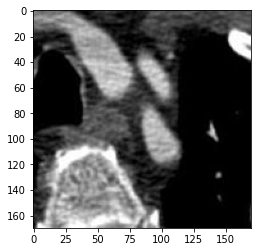

In [17]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the Ultrasound scan is:", image.shape)
plt.imshow(np.squeeze(image[30,:, :,:]),cmap="gray")

In [18]:
def get_model(width=170, height=170, depth=269):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth,width, height,3))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(units=512, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=170, height=170, depth=269)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 269, 170, 170, 3) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 267, 168, 168, 64) 5248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 133, 84, 84, 64)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 133, 84, 84, 64)   256       
_________________________________________________________________
global_average_pooling3d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


In [1]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [2]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )